## Setting up a RAG solution

In this first task, we will setup the Workbench environment, create a RAG solution from Alphabets 2022 financial annual report and perform some queries to the report. To store the embeddings we use Chroma, an open-source embeddings database that makes it straightforward to store embeddings.

In [1]:
!pip3 install --upgrade --user google-cloud-aiplatform umap-learn tqdm pypdf

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [2]:
import IPython
from IPython.display import Markdown, display
import time

app = IPython.Application.instance()
app.kernel.do_shutdown(True)

{'status': 'ok', 'restart': True}

In [1]:
PROJECT = !gcloud config get-value project
PROJECT_ID = PROJECT[0]
LOCATION = "us-west1"

In [2]:
from vertexai.preview.generative_models import GenerativeModel
from vertexai.language_models import TextEmbeddingModel
text_embedding_model = TextEmbeddingModel.from_pretrained("text-embedding-004")
model = GenerativeModel('gemini-pro')

In [3]:
import urllib.request

# download alphabet's annual pdf report
url = "https://abc.xyz/assets/d4/4f/a48b94d548d0b2fdc029a95e8c63"
file = "2022-alphabet-annual-report.pdf"

urllib.request.urlretrieve(f"{url}/{file}", filename=f"{file}")

('2022-alphabet-annual-report.pdf',
 <http.client.HTTPMessage at 0x7f43223b5330>)

In [4]:
!pip install PyPDF2
import PyPDF2

# Open the PDF file in binary mode
with open('2022-alphabet-annual-report.pdf', 'rb') as file:
    # Create a PdfFileReader object
    pdf_reader = PyPDF2.PdfReader(file)
    pdf_texts = [p.extract_text().strip() for p in pdf_reader.pages]

    # Filter the empty strings
    pdf_texts = [text for text in pdf_texts if text]

    print(pdf_texts[0])

To our investors,
2022 was a year full of change and uncertainty around 
the world. In February, when war broke out in Ukraine, our teams worked around-the-clock to make sure our products were helpful to people who needed them, from providing trustworthy information on Search to disrupting cyberattacks to partnering with the government to deploy air raid alerts. In March, I traveled to Warsaw, Poland, where I met Googlers hosting families who sought refuge, talked with entrepreneurs using our office spaces, and saw how our products like Google Translate were helping Ukrainians find a bit of hope and connection.
By late spring, the tech industry was adjusting to a 
more challenging macroeconomic environment, and as a company we embarked on efforts to sharpen our focus and make sure our efforts are aligned with our highest priorities. Near the end of the year, AI reached an inflection point, made possible by our foundational breakthroughs like Transformer and advances in diffusion models

Split the PDF into chunks so that we can create embedding out of them. The embedding's APIs and the LLM have token limits, that's why we need to split the text into smaller units as opposed to sending the whole text.

In [5]:
!pip install langchain sentence-transformers
from langchain.text_splitter import RecursiveCharacterTextSplitter, SentenceTransformersTokenTextSplitter
character_splitter = RecursiveCharacterTextSplitter(
    separators=["\n\n", "\n", ". ", " ", ""],
    chunk_size=1000,
    chunk_overlap=0
)
character_split_texts = character_splitter.split_text('\n\n'.join(pdf_texts))

print(character_split_texts[10])
print(f"\nTotal chunks: {len(character_split_texts)}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 22.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 906.4/906.4 MB 15.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 37.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 35.1 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 135.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 32.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 19.8 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 85.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 94.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 39.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 50.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

Create more chunks if the size of the existing chunk is too big. In this case, we define too big as 256 tokens.

In [6]:
token_splitter = SentenceTransformersTokenTextSplitter(chunk_overlap=0, tokens_per_chunk=256)

token_split_texts = []
for text in character_split_texts:
    token_split_texts += token_splitter.split_text(text)

print(token_split_texts[10])
print(f"\nTotal chunks: {len(token_split_texts)}")

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

5 year in review 2022 multisearch with multisearch, people can now search with both images and text at the same time in google lens.

Total chunks: 511


In [7]:
!pip3 install chromadb==0.5.3
!pip3 install google-generativeai
import chromadb
import os
from chromadb.utils.embedding_functions import SentenceTransformerEmbeddingFunction
# import chromadb.utils.embedding_functions as embedding_functions

# import getpass
# import os

# getpass will prompt for an API Key
# The API Key is needed for Chroma DB
# API_KEY = getpass.getpass("Provide your Google API Key")

# embedding_function = embedding_functions.GooglePalmEmbeddingFunction(api_key=creds.token)

embedding_function = SentenceTransformerEmbeddingFunction()
print(embedding_function([token_split_texts[10]]))

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
INFO: pip is looking at multiple versions of opentelemetry-sdk to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 559.5/559.5 kB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 64.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 51.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 119.7 MB/s eta 0:00:00
  Created wheel for pypika: filename=PyPika-0.48.9-py2.py3-none-any.whl size=53725 sha256=6841e2baad88a5b0c214ff6688b07d7d3da6c0a956bb6d2876bb77a0aaee912c
  Stored in directory: /home/jupyter/.cache/pip/wheels/e1/26/51/d0bffb3d2fd82256676d7ad3003faea3bd6dddc9577af665f4
Successfully built pypika
  Attempting uninstall: kubernetes
    Found existing installation: kubernetes 26.1.0
    Uninstalli

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


INFO: pip is looking at multiple versions of google-api-core[grpc] to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of google-api-core[grpc] to determine which version is compatible with other requirements. This could take a while.
INFO: This is taking longer than usual. You might need to provide the dependency resolver with stricter constraints to reduce runtime. See https://pip.pypa.io/warnings/backtracking for guidance. If you want to abort this run, press Ctrl + C.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 760.0/760.0 kB 19.9 MB/s eta 0:00:00
  Attempting uninstall: google-api-core
    Found existing installation: google-api-core 2.23.0
    Uninstalling google-api-core-2.23.0:
      Successfully uninstalled google-api-core-2.23.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency 

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

[[-0.03299040347337723, -0.03994394838809967, 0.02768322080373764, -0.020394684746861458, 0.010316920466721058, -0.013435319997370243, -0.11188780516386032, 0.0020084811840206385, -0.008219876326620579, -0.054634515196084976, 0.05009115859866142, 0.060834359377622604, 0.050288472324609756, 0.04027774557471275, 0.0002621527237351984, -0.01453626248985529, -0.054342564195394516, 0.0022568206768482924, -0.03845825418829918, -0.053221721202135086, 0.0584506019949913, -0.04633062705397606, 0.11275571584701538, -0.0909026712179184, -0.005574648734182119, 0.02450973354279995, -0.14071720838546753, -0.09735380113124847, -0.0076984865590929985, 0.018437139689922333, -5.31673249497544e-05, 0.0346691757440567, -0.006346573121845722, 0.11858687549829483, -0.0844186320900917, 0.0539005771279335, -0.06958915293216705, 0.0504479855298996, -0.010030870325863361, 0.016402777284383774, -0.042457979172468185, -0.036958418786525726, -0.03685655817389488, -0.059337131679058075, 0.03196948766708374, 0.02155

Create embedings and store them in the chroma database.


In [8]:
chroma_client = chromadb.Client()
print("collection")
chroma_collection = chroma_client.create_collection("alphabet_annual_report_2022", embedding_function=embedding_function)
print("created")
ids = [str(i) for i in range(len(token_split_texts))]
print("adding")
chroma_collection.add(ids=ids, documents=token_split_texts)
chroma_collection.count()

collection
created
adding


511

In [11]:
query = "What was the total revenue?"

results = chroma_collection.query(query_texts=[query], n_results=5)
retrieved_documents = results['documents'][0]

for document in retrieved_documents:
    print(document)
    print('\n')

accrued revenue share 1, 639 1, 682 ( 445 ) deferred revenue 635 774 367


for additional details, including a reconciliation of the u. s. federal statutory rate to our effective tax rate, see note 14 of the notes to consolidated financial statements included in item 8 of this annual report on form 10 - k. executive overview the following table summarizes our consolidated financial results ( in millions, except for per share information and percentages ) : year ended december 31, 2021 2022 $ change % change consolidated revenues $ 257, 637 $ 282, 836 $ 25, 199 10 % change in consolidated constant currency revenues ( 1 ) 14 % cost of revenues $ 110, 939 $ 126, 203 $ 15, 264 14 % operating expenses $ 67, 984 $ 81, 791 $ 13, 807 20 % operating income $ 78, 714 $ 74, 842 $ ( 3, 872 ) ( 5 ) % operating margin 31 % 26 % ( 5 ) % other income ( expense ), net $ 12, 020 $ ( 3, 514 ) $ ( 15, 534 ) ( 129 ) % net income $ 76, 033 $ 59, 972 $ ( 16, 061 ) ( 21 ) % diluted eps $ 5. 61 $ 4. 56 $ ( 1. 

Use a RAG to answer the question given the information that was looked up from the database.

In [12]:
def rag(query, retrieved_documents, model):
    information = "\n\n".join(retrieved_documents)

    prompt = (f'You are a helpful expert financial research assistant.\n'
    f'Your users are asking questions about information contained in an annual report.\n'
    f'You will be shown the user\'s question, and the relevant information from the annual report.\n'
    f'Answer the user\'s question using only this information.\n\n'
    f'Question: {query}. \n Information: {information}')
    
    responses = model.generate_content(prompt, stream=False)
    return responses.text

response = rag(query=query, retrieved_documents=retrieved_documents, model=model)
print(response)

The total revenue for the year ended December 31, 2022, was $282,836 million. This represents a 10% increase from the previous year.


## Explore embeddings distribution with user queries

In [13]:
import umap.umap_ as umap
import numpy as np
from tqdm import tqdm

embeddings = chroma_collection.get(include=['embeddings'])['embeddings']
umap_transform = umap.UMAP(random_state=0, transform_seed=0).fit(embeddings)

def project_embeddings(embeddings, umap_transform):
    umap_embeddings = np.empty((len(embeddings),2))
    for i, embedding in enumerate(tqdm(embeddings)): 
        umap_embeddings[i] = umap_transform.transform([embedding])
    return umap_embeddings

projected_dataset_embeddings = project_embeddings(embeddings, umap_transform)

/home/jupyter/.local/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
100%|██████████| 511/511 [00:02<00:00, 201.97it/s]


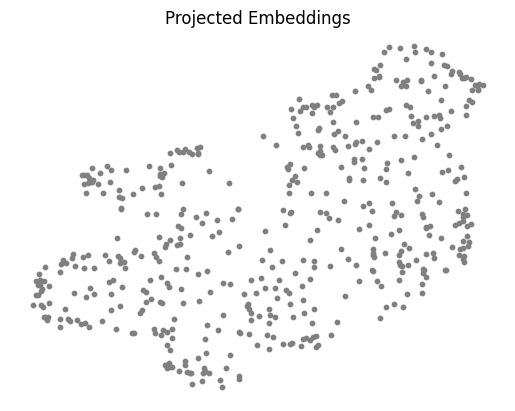

In [14]:
import matplotlib.pyplot as plt

def plot(title='Projected Embeddings', projected_dataset_embeddings=[], projected_query_embedding=[], projected_retrieved_embeddings=[]):
    # Plot the projected query and retrieved documents in the embedding space
    plt.figure()
    plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1], s=10, color='gray')
    if len(projected_query_embedding) > 0:
        plt.scatter(projected_query_embedding[:, 0], projected_query_embedding[:, 1], s=150, marker='X', color='r')
    if len(projected_retrieved_embeddings) > 0:
        plt.scatter(projected_retrieved_embeddings[:, 0], projected_retrieved_embeddings[:, 1], s=100, facecolors='none', edgecolors='g')

    plt.gca().set_aspect('equal', 'datalim')
    plt.title(f'{title}')
    plt.axis('off')

plot(projected_dataset_embeddings=projected_dataset_embeddings)

Ask the same question to the database again, but this time retrieve the embeddings in addition to the documents.

In [15]:
query = "What was the total revenue?"

results = chroma_collection.query(query_texts=query, n_results=5, include=['documents', 'embeddings'])

retrieved_documents = results['documents'][0]

for document in results['documents'][0]:
    print(document)
    print('')

accrued revenue share 1, 639 1, 682 ( 445 ) deferred revenue 635 774 367

for additional details, including a reconciliation of the u. s. federal statutory rate to our effective tax rate, see note 14 of the notes to consolidated financial statements included in item 8 of this annual report on form 10 - k. executive overview the following table summarizes our consolidated financial results ( in millions, except for per share information and percentages ) : year ended december 31, 2021 2022 $ change % change consolidated revenues $ 257, 637 $ 282, 836 $ 25, 199 10 % change in consolidated constant currency revenues ( 1 ) 14 % cost of revenues $ 110, 939 $ 126, 203 $ 15, 264 14 % operating expenses $ 67, 984 $ 81, 791 $ 13, 807 20 % operating income $ 78, 714 $ 74, 842 $ ( 3, 872 ) ( 5 ) % operating margin 31 % 26 % ( 5 ) % other income ( expense ), net $ 12, 020 $ ( 3, 514 ) $ ( 15, 534 ) ( 129 ) % net income $ 76, 033 $ 59, 972 $ ( 16, 061 ) ( 21 ) % diluted eps $ 5. 61 $ 4. 56 $ ( 1. 0

Embed the question and answer and transform it into two dimentions.

In [16]:
query_embedding = embedding_function([query])[0]
retrieved_embeddings = results['embeddings'][0]

projected_query_embedding = project_embeddings([query_embedding], umap_transform)
projected_retrieved_embeddings = project_embeddings(retrieved_embeddings, umap_transform)

100%|██████████| 5/5 [00:00<00:00, 179.32it/s]


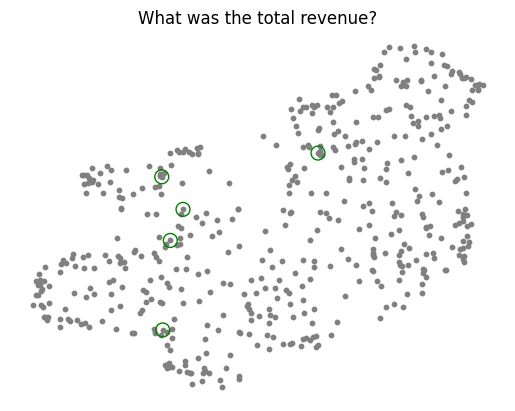

In [17]:
plot(title=query, projected_dataset_embeddings=projected_dataset_embeddings, projected_query_embedding=[], projected_retrieved_embeddings=projected_retrieved_embeddings)

In [18]:
query = "What is the strategy around artificial intelligence (AI) ?"
results = chroma_collection.query(query_texts=query, n_results=5, include=['documents', 'embeddings'])

retrieved_documents = results['documents'][0]

for document in results['documents'][0]:
    print(document)
    print('')

to irrelevance over time, especially in technology, where change tends to be revolutionary, not evolutionary. people thought we were crazy when we acquired youtube and android and when we launched chrome, but those efforts have matured into major platforms for digital video and mobile devices and a safer, popular browser. we continue to look toward the future and to invest for the long term within each of our segments. as we said in the original founders ’ letter, we will not shy away from high - risk, high - reward projects that we believe in, as they are the key to our long - term success. the power of ai we believe that ai is a foundational and transformational technology that will provide compelling and helpful benefits to people and society through its capacity to assist, complement, empower, and inspire people in almost every field of human endeavor. as

are making across our businesses, such as in ai, reflect our ongoing efforts to innovate and provide products and services that

In [19]:
query_embedding = embedding_function([query])[0]
retrieved_embeddings = results['embeddings'][0]

projected_query_embedding = project_embeddings([query_embedding], umap_transform)
projected_retrieved_embeddings = project_embeddings(retrieved_embeddings, umap_transform)

100%|██████████| 5/5 [00:00<00:00,  6.83it/s]


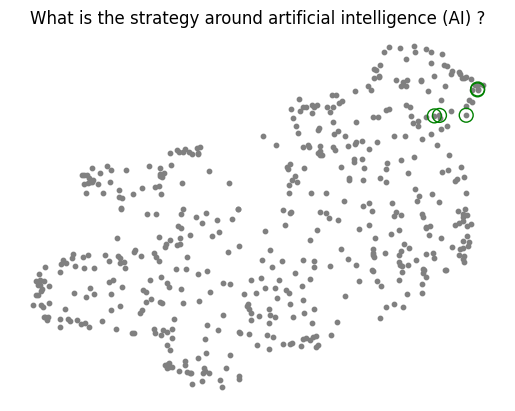

In [20]:
plot(title=query, projected_dataset_embeddings=projected_dataset_embeddings, projected_query_embedding=[], projected_retrieved_embeddings=projected_retrieved_embeddings)

Try all these again with another question that might be contained in the dataset to see that results are still close to one another.

our operating results have fluctuated, and may in the future fluctuate, as a result of a number of factors, many outside of our control, including the cyclicality and seasonality in our business and geopolitical events. as a result, comparing our operating results ( including our expenses as a percentage of our revenues ) on a period - to - period basis may not be meaningful, and our past results should not be relied on as an indication of our future performance. consequently, our operating results in future quarters may fall below expectations. acquisitions, joint ventures, investments, and divestitures could result in operating difficulties, dilution, and other consequences that could harm our business, financial condition, and operating results. acquisitions, joint ventures, investments, and divestitures are important elements of our overall corporate strategy and use of capital,

customer contracts with commitments for performance obligations, including our estimate of the remainin

100%|██████████| 5/5 [00:00<00:00, 170.43it/s]


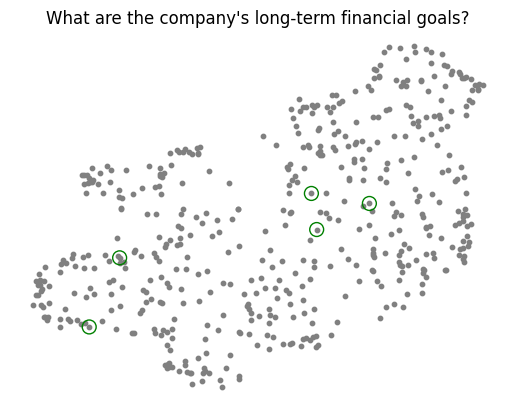

In [21]:
query = "What are the company's long-term financial goals?"
results = chroma_collection.query(query_texts=query, n_results=5, include=['documents', 'embeddings'])

retrieved_documents = results['documents'][0]

for document in results['documents'][0]:
    print(document)
    print('')

query_embedding = embedding_function([query])[0]
retrieved_embeddings = results['embeddings'][0]

projected_query_embedding = project_embeddings([query_embedding], umap_transform)
projected_retrieved_embeddings = project_embeddings(retrieved_embeddings, umap_transform)

plot(title=query, projected_dataset_embeddings=projected_dataset_embeddings, projected_query_embedding=[], projected_retrieved_embeddings=projected_retrieved_embeddings)

Now, use an unrelated query and observe how the results are more scattered around. Notice that the algorithm always returns close neighbors even if they are far appart. This is an indication that is returning results that are not necesseraly related to the query

careers, and be happy, healthy, and productive. we offer industry - leading benefits and programs to take care of the diverse needs of our employees and their families, including opportunities for career growth and development, resources to support their financial health, and access to excellent healthcare choices. our competitive compensation programs help us to attract and retain top candidates, and we will continue to invest in recruiting talented people to technical and non - technical roles, and rewarding them well. we provide a variety of high quality training and support to managers to build and strengthen their capabilities — ranging from courses for new managers, to learning resources that help them provide feedback and manage performance, to coaching and individual support.

other bets 753 1, 068 hedging gains ( losses ) 149 1, 960 total revenues $ 257, 637 $ 282, 836

we continue to make significant research and development investments in areas of strategic focus as we seek 

100%|██████████| 5/5 [00:00<00:00, 179.19it/s]


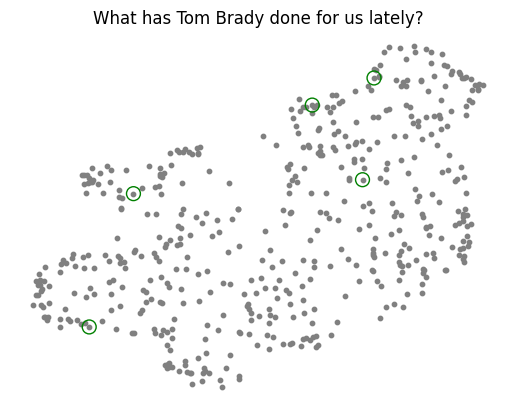

In [22]:
query = "What has Tom Brady done for us lately?"
results = chroma_collection.query(query_texts=query, n_results=5, include=['documents', 'embeddings'])

retrieved_documents = results['documents'][0]

for document in results['documents'][0]:
    print(document)
    print('')

query_embedding = embedding_function([query])[0]
retrieved_embeddings = results['embeddings'][0]

projected_query_embedding = project_embeddings([query_embedding], umap_transform)
projected_retrieved_embeddings = project_embeddings(retrieved_embeddings, umap_transform)

plot(title=query, projected_dataset_embeddings=projected_dataset_embeddings, projected_query_embedding=[], projected_retrieved_embeddings=projected_retrieved_embeddings)

## Query augmentation

One way of improving the results from queries is by getting more results of similar queries. This can be done either by creating similar queries or by sending an answer of what you might expect, so that you attach more context. In this task, you learn to expand your queries leveraging LLMs to do the heavy lifting.

In [23]:
def augment_query_generated(query, model):
    information = "\n\n".join(retrieved_documents)

    prompt = (f'You are a helpful expert financial research assistant.\n'
    f'Provide an example answer to the given question, that might be found in a document like an annual report.\n'
    f'Question: {query}.')
    
    responses = model.generate_content(prompt, stream=False)
    return responses.text

original_query = "Was there significant turnover in the executive team?"
hypothetical_answer = augment_query_generated(original_query, model)

joint_query = f"{original_query} {hypothetical_answer}"
print(joint_query)

Was there significant turnover in the executive team? ## Executive Team Turnover

There was no significant turnover in the executive team during the fiscal year. The executive team remained stable, with all members continuing in their roles throughout the year. This continuity of leadership has been instrumental in driving the company's success and ensuring a smooth implementation of our strategic initiatives.

For more details, please refer to the "Management's Discussion and Analysis" section of the annual report, which provides an overview of the executive team and their responsibilities. You can also find the bios of each executive team member in the "Corporate Governance" section of the report.


Perform the query with the new augmented query.


In [24]:
results = chroma_collection.query(query_texts=joint_query, n_results=5, include=['documents', 'embeddings'])
retrieved_documents = results['documents'][0]

for doc in retrieved_documents:
    print(doc)
    print('')

32 alphabet inc. ● annual report part ii item 7 management ’ s discussion and anal ysis of financial condition and results of operations sales and marketing the following table presents sales and marketing expenses ( in millions, except percentages ) : year ended december 31, 2021 2022 sales and marketing expenses $ 22, 912 $ 26, 567 sales and marketing expenses as a percentage of revenues 9 % 9 % sales and marketing expenses increased $ 3. 7 billion from 2021 to 2022, primarily driven by an increase in compensation expenses of $ 1. 8 billion, largely resulting from a 19 % increase in average headcount, and an increase in advertising and promotional activities of $ 1. 3 billion. general and administrative the following table presents general and administrative expenses ( in millions, except percentages ) : year ended december 31, 2021 2022 general and administrative expenses $ 13, 510 $ 15, 724 general and administrative expenses as a percentage of revenues 5 % 6 %

41 alphabet inc. ● 

In [25]:
retrieved_embeddings = results['embeddings'][0]
original_query_embedding = embedding_function([original_query])
augmented_query_embedding = embedding_function([joint_query])

projected_original_query_embedding = project_embeddings(original_query_embedding, umap_transform)
projected_augmented_query_embedding = project_embeddings(augmented_query_embedding, umap_transform)
projected_retrieved_embeddings = project_embeddings(retrieved_embeddings, umap_transform)

100%|██████████| 5/5 [00:00<00:00, 154.53it/s]


(-1.4102312833070756, 8.613915792107582, 1.0237262845039368, 8.612713277339935)

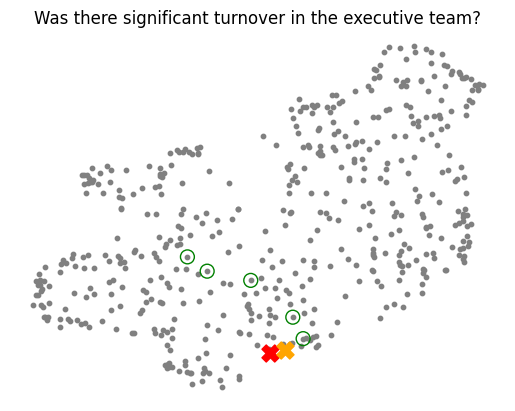

In [26]:
plt.figure()
plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1], s=10, color='gray')
plt.scatter(projected_retrieved_embeddings[:, 0], projected_retrieved_embeddings[:, 1], s=100, facecolors='none', edgecolors='g')
plt.scatter(projected_original_query_embedding[:, 0], projected_original_query_embedding[:, 1], s=150, marker='X', color='r')
plt.scatter(projected_augmented_query_embedding[:, 0], projected_augmented_query_embedding[:, 1], s=150, marker='X', color='orange')

plt.gca().set_aspect('equal', 'datalim')
plt.title(f'{original_query}')
plt.axis('off')

Augment the query with a additional queries.


In [27]:
def augment_multiple_query(query, model):
    information = "\n\n".join(retrieved_documents)

    prompt = (f'You are a helpful expert financial research assistant.\n'
    f'Your users are asking questions about an annual report.\n'
    f'Suggest up to five additional related questions to help them find the information they need, for the provided question.\n'
    f'Suggest only short questions without compound sentences. Suggest a variety of questions that cover different aspects of the topic.\n'
    f'Make sure they are complete questions, and that they are related to the original question.\n'
    f'Output one question per line. Do not number the questions.\n'
    f'Question: {query}.')
    
    responses = model.generate_content(prompt, stream=False)
    return responses.text

original_query = "What were the most important factors that contributed to increases in revenue?"
augmented_queries = augment_multiple_query(original_query, model)

joint_query = f"{original_query} \n{augmented_queries}"
print(joint_query)

What were the most important factors that contributed to increases in revenue? 
How did the company's pricing strategy affect revenue?
What role did new product launches play in driving revenue growth?
Did changes in market share contribute to increased revenue?
How did acquisitions or divestitures impact revenue? 
What was the impact of foreign exchange fluctuations on revenue?


Retrieve answers for all of these queries.


In [28]:
queries = [original_query] + augmented_queries.split('\n')
results = chroma_collection.query(query_texts=queries, n_results=5, include=['documents', 'embeddings'])

retrieved_documents = results['documents']

# Deduplicate the retrieved documents
unique_documents = set()
for documents in retrieved_documents:
    for document in documents:
        unique_documents.add(document)

for i, documents in enumerate(retrieved_documents):
    print(f"Query: {queries[i]}")
    print('')
    print("Results:")
    for doc in documents:
        print(doc)
        print('')
    print('-'*100)

Query: What were the most important factors that contributed to increases in revenue?

Results:
. due to these factors and the evolving nature of our business, our historical revenue growth rate and historical operating margin may not be indicative of our future performance. for additional information, see trends in our business and financial effect and revenues and monetization metrics in part ii, item 7 of this annual report on form 10 - k.

our revenue growth rate could decline over time, and we anticipate downward pressure on our operating margin in the future. our revenue growth rate could decline over time as a result of a number of factors, including changes in the devices and modalities used to access our products and services ; changes in geographic mix ; deceleration or declines in advertiser spending ; competition ; customer usage and demand for our products ; decreases in our pricing of our products and services ; ongoing product and policy changes ; and shifts to lower pri

Project the queries embeddings into a 2-dimensional space.


In [30]:
original_query_embedding = embedding_function([original_query])
augmented_query_embeddings = embedding_function(augmented_queries)

project_original_query = project_embeddings(original_query_embedding, umap_transform)
project_augmented_queries = project_embeddings(augmented_query_embeddings, umap_transform)

100%|██████████| 301/301 [00:01<00:00, 186.23it/s]


Project the answer embeddings into a 2-dimensional space.


In [32]:
result_embeddings = results['embeddings']
result_embeddings = [item for sublist in result_embeddings for item in sublist]
projected_result_embeddings = project_embeddings(result_embeddings, umap_transform)

100%|██████████| 30/30 [00:00<00:00, 169.72it/s]


Plot the queries and answers to visualize their representation in space.


(-1.4102312833070756, 8.613915792107582, 1.0237262845039368, 8.612713277339935)

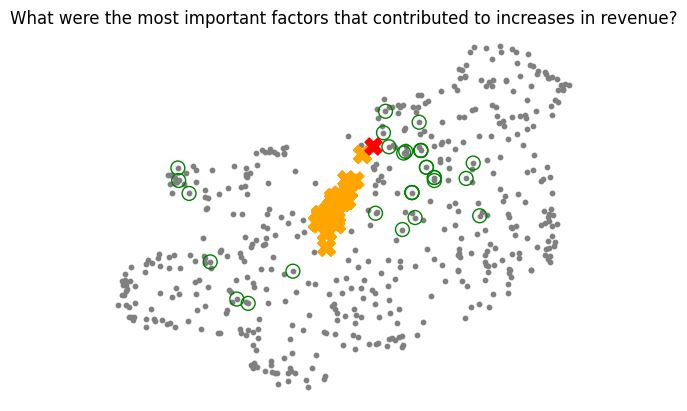

In [34]:
import matplotlib.pyplot as plt

plt.figure()
plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1], s=10, color='gray')
plt.scatter(project_augmented_queries[:, 0], project_augmented_queries[:, 1], s=150, marker='X', color='orange')
plt.scatter(projected_result_embeddings[:, 0], projected_result_embeddings[:, 1], s=100, facecolors='none', edgecolors='g')
plt.scatter(project_original_query[:, 0], project_original_query[:, 1], s=150, marker='X', color='r')

plt.gca().set_aspect('equal', 'datalim')
plt.title(f'{original_query}')
plt.axis('off')

## Re-ranking results

With the query expansion technique that we just discussed, we increased the cardinality of responses. We have a new problem now. The high amount of responses might be larges than the LLM's input token limit and, it will be more expensive to process such a high amount of tokens, since we are billed per token. One solution to this problem is to rerank the results and only send the most relevant ones. Now, instead of using the same cosine-similarity method as before, you could use a cross-encoder, a method that usually yields better results.

In [36]:
from sentence_transformers import CrossEncoder
cross_encoder = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-6-v2')

config.json:   0%|          | 0.00/794 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Create unique pairs of query to document.


In [37]:
pairs = []
for doc in unique_documents:
    pairs.append([original_query, doc])

Compute an print the similarity between the pairs.

In [39]:
scores = cross_encoder.predict(pairs)

print("Scores:")
for score in scores:
    print(score)

Scores:
0.4199409
-9.594553
-7.6591444
-4.737796
-10.999705
-5.3730783
-7.320813
-11.038466
-6.0731077
-10.157861
-8.229429
-11.080077
-2.2096562
-4.349068
-10.22899
-10.009102
-5.3221684
-2.96743
-11.144753
-10.323975
-5.3835382
1.3391347
-11.062307
-10.957918


In [40]:
print("New Ordering:")
ranked_docs=['']*len(scores)
i = 0
for position in np.argsort(scores)[::-1]:
    ranked_docs[position] = pairs[i][1]
    i+=1
    print(position)

New Ordering:
21
0
12
17
13
3
16
5
20
8
6
2
10
1
15
9
14
19
23
4
7
22
11
18


In [41]:
ranked_docs[:5]

['31 alphabet inc. ● annual report part ii item 7 management ’ s discussion and anal ysis of financial condition and results of operations the following table presents the foreign exchange effect on international revenues and total revenues ( in millions, except percentages ) : year ended december 31, 2022 % change from prior period year ended december 31, less fx effectconstant currency revenuesas reportedless hedging effectless fx effectconstant currency revenues 2021 2022 united states $ 117, 854 $ 134, 814 $ 0 $ 134, 814 14 % 0 % 14 % emea 79, 107 82, 062 ( 8, 979 ) 91, 041 4 % ( 11 ) % 15 % apac 46, 123 47, 024 ( 3, 915 ) 50, 939 2 % ( 8 ) % 10 % other americas 14, 404 16, 976 ( 430 ) 17, 406 18 % ( 3 ) % 21 % revenues, excluding hedging effect 257, 488 280, 876 ( 13, 324 ) 294, 200 9 % ( 5 ) % 14 % hedging gains ( losses ) 149 1, 960 total revenues ( 1 ) $ 257, 637 $ 282, 836 $ 294, 200 10',
 'continued expansion of our business into new fields, including products and services su

In [42]:
response = rag(query=original_query, retrieved_documents=ranked_docs[:5], model=model)
print(original_query)
print(response)

What were the most important factors that contributed to increases in revenue?
## Factors Contributing to Revenue Increases:

Based on the information provided, the following factors contributed to Alphabet Inc.'s revenue increase in 2022:

**1. Organic Growth:**

* **Strong Core Business:** The company experienced a 14% increase in revenue in its core business, driven by strong sales in the United States and other key markets.
* **Expansion into New Fields:** Continued expansion into new fields, including hardware, Google Cloud, and subscription products, generated additional revenue streams.

**2. Currency Fluctuations:**

* **Favorable Exchange Rates:** Although the company reports revenues "excluding the effect of foreign exchange rate movements," the 4% increase in the "as reported" revenue in EMEA suggests that favorable exchange rates positively impacted reported revenue.

**3. Investments in Other Bets:**

* **Significant Investments:** While not directly contributing to core r

## Embedding Adapters

Another improvement that we can make is instead of getting more answers and reranking, train the embedding model to work with our dataset based on user queries. This is a form a of fine tuning that you can do on your own.

In [43]:
def generate_queries(model):

    prompt = (f'You are a helpful expert financial research assistant.\n'
    f'You help users analyze financial statements to better understand companies.\n'
    f'Suggest 10 to 15 short questions that are important to ask when analyzing an annual report.\n'
    f'Do not output any compound questions (questions with multiple sentences or conjunctions).\n'
    f'Output each question on a separate line divided by a newline.')
    
    responses = model.generate_content(prompt, stream=False)
    return responses.text.split('\n')

generated_queries = generate_queries(model)
for query in generated_queries:
    print(query)

## 10 Questions for Analyzing an Annual Report:

**Financial Performance:**

* What was the company's revenue for the past year, and how does it compare to previous years?
* What was the company's net income for the past year, and how does it compare to previous years?
* What are the company's gross profit margins and how have they trended over time?
* Did the company generate positive or negative operating cash flow in the past year?

**Financial Health:**

* What is the company's current ratio and what does it indicate about its short-term liquidity?
* What is the company's debt-to-equity ratio and how does it compare to industry averages?
* Has the company's working capital position changed significantly throughout the year?

**Growth & Future Prospects:**

* What are the company's plans for future growth?
* Is the company investing in research and development to drive future innovation?
* What are the main competitive threats the company faces in its industry?

**Additional Conside

Search answers for those queries

In [44]:
results = chroma_collection.query(query_texts=generated_queries, n_results=10, include=['documents', 'embeddings'])
retrieved_documents = results['documents']

Evaluate the results in 1 for relevant and -1 for irrelevant answers.


In [45]:
def evaluate_results(query, statement, model):

    prompt = (f'You are a helpful expert financial research assistant.\n'
    f'You help users analyze financial statements to better understand companies.\n'
    f'For the given query, evaluate whether the following satement is relevant.\n'
    f'Output only \'yes\' or \'no\'.\n'
    f'Question: {query}, Statement: {statement}.')
    
    responses = model.generate_content(prompt, stream=False)
    if responses.text == 'yes':
        return 1
    return -1

retrieved_embeddings = results['embeddings']
query_embeddings = embedding_function(generated_queries)

Extract the documents and queries into their own lists.


In [47]:
adapter_query_embeddings = []
adapter_doc_embeddings = []
adapter_labels = []

for q, query in enumerate(tqdm(generated_queries)):
    for d, document in enumerate(retrieved_documents[q]):
        adapter_query_embeddings.append(query_embeddings[q])
        adapter_doc_embeddings.append(retrieved_embeddings[q][d])
        adapter_labels.append(evaluate_results(query, document, model))

len(adapter_labels)

100%|██████████| 26/26 [03:10<00:00,  7.34s/it]


260

Install PyTorch so that we can train the embedding model based on relevant answers.

In [48]:
!pip install torch

import torch

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [49]:
adapter_query_embeddings = torch.Tensor(np.array(adapter_query_embeddings))
adapter_doc_embeddings = torch.Tensor(np.array(adapter_doc_embeddings))
adapter_labels = torch.Tensor(np.expand_dims(np.array(adapter_labels),1))

dataset = torch.utils.data.TensorDataset(adapter_query_embeddings, adapter_doc_embeddings, adapter_labels)

Set up the model with cosine similarity, so that embeddings with label 1 are similar and -1 are dissimilar.

In [50]:
def model(query_embedding, document_embedding, adaptor_matrix):
    updated_query_embedding = torch.matmul(adaptor_matrix, query_embedding)
    return torch.cosine_similarity(updated_query_embedding, document_embedding, dim=0)

In [51]:
def mse_loss(query_embedding, document_embedding, adaptor_matrix, label):
    return torch.nn.MSELoss()(model(query_embedding, document_embedding, adaptor_matrix), label)

Initialize the adaptor matrix.


In [52]:
mat_size = len(adapter_query_embeddings[0])
adapter_matrix = torch.randn(mat_size, mat_size, requires_grad=True)

Train the adaptor matrix using 100 steps by iteratively update a vector such that if I take that vector and multiply it by these inputs (query embeddings) then compare that result to this vector (this example's retrieved document vector), I get a score closer to (this example's -1 or 1 label).

In [53]:
min_loss = float('inf')
best_matrix = None

for epoch in tqdm(range(100)):
    for query_embedding, document_embedding, label in dataset:
        loss = mse_loss(query_embedding, document_embedding, adapter_matrix, label)

        if loss < min_loss:
            min_loss = loss
            best_matrix = adapter_matrix.clone().detach().numpy()

        loss.backward()
        with torch.no_grad():
            adapter_matrix -= 0.01 * adapter_matrix.grad
            adapter_matrix.grad.zero_()       

  0%|          | 0/100 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 100/100 [00:26<00:00,  3.77it/s]


Print the loss. Notice there is almost a 30% increase in accuracy.


In [54]:
print(f"Best loss: {min_loss.detach().numpy()}")

Best loss: 0.6710281372070312


Create a scaled vector based on the best matrix that we computed.

In [55]:
test_vector = torch.ones((mat_size,1))
scaled_vector = np.matmul(best_matrix, test_vector).numpy()

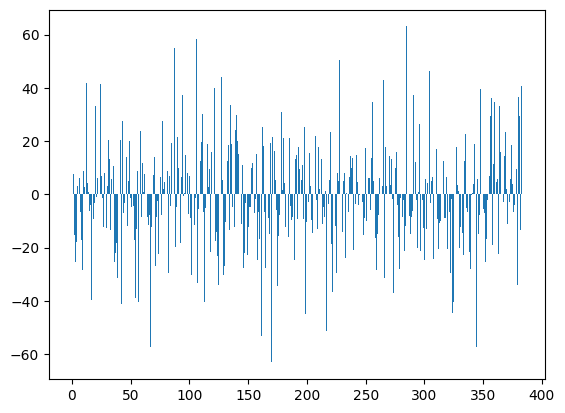

In [56]:
import matplotlib.pyplot as plt
plt.bar(range(len(scaled_vector)), scaled_vector.flatten())
plt.show()

Get the adapted query embeddings to compare them with the original values retrieved.

In [57]:
query_embeddings = embedding_function(generated_queries)
adapted_query_embeddings = np.matmul(best_matrix, np.array(query_embeddings).T).T

projected_query_embeddings = project_embeddings(query_embeddings, umap_transform)
projected_adapted_query_embeddings = project_embeddings(adapted_query_embeddings, umap_transform)

100%|██████████| 26/26 [00:00<00:00, 175.90it/s]


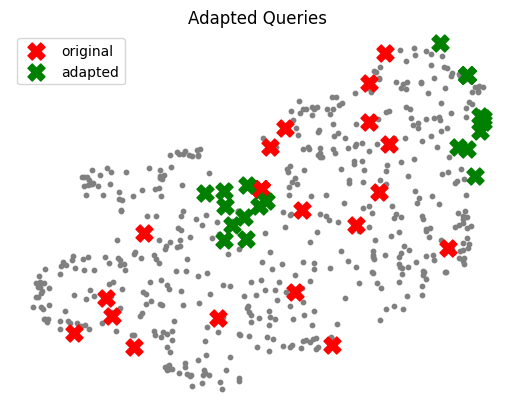

In [58]:
# Plot the projected query and retrieved documents in the embedding space
plt.figure()
plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1], s=10, color='gray')
plt.scatter(projected_query_embeddings[:, 0], projected_query_embeddings[:, 1], s=150, marker='X', color='r', label="original")
plt.scatter(projected_adapted_query_embeddings[:, 0], projected_adapted_query_embeddings[:, 1], s=150, marker='X', color='green', label="adapted")

plt.gca().set_aspect('equal', 'datalim')
plt.title("Adapted Queries")
plt.axis('off')
plt.legend()